Epoch 1/200


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5641 - mae: 0.5637 - val_loss: 0.4830 - val_mae: 0.5481
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5126 - mae: 0.5234 - val_loss: 0.4338 - val_mae: 0.5014
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4801 - mae: 0.4964 - val_loss: 0.3891 - val_mae: 0.4545
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4330 - mae: 0.4520 - val_loss: 0.3443 - val_mae: 0.4019
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4186 - mae: 0.4434 - val_loss: 0.3050 - val_mae: 0.3490
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3687 - mae: 0.3884 - val_loss: 0.2674 - val_mae: 0.2891
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3317 - mae: 0.3547 - val_loss: 0.2339 - val_mae: 0.2217
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3215 - mae: 0.3510 - val_loss: 0.2106 - val_mae: 0.1771
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3045 - mae: 0.3173 - val_l

c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) Deja

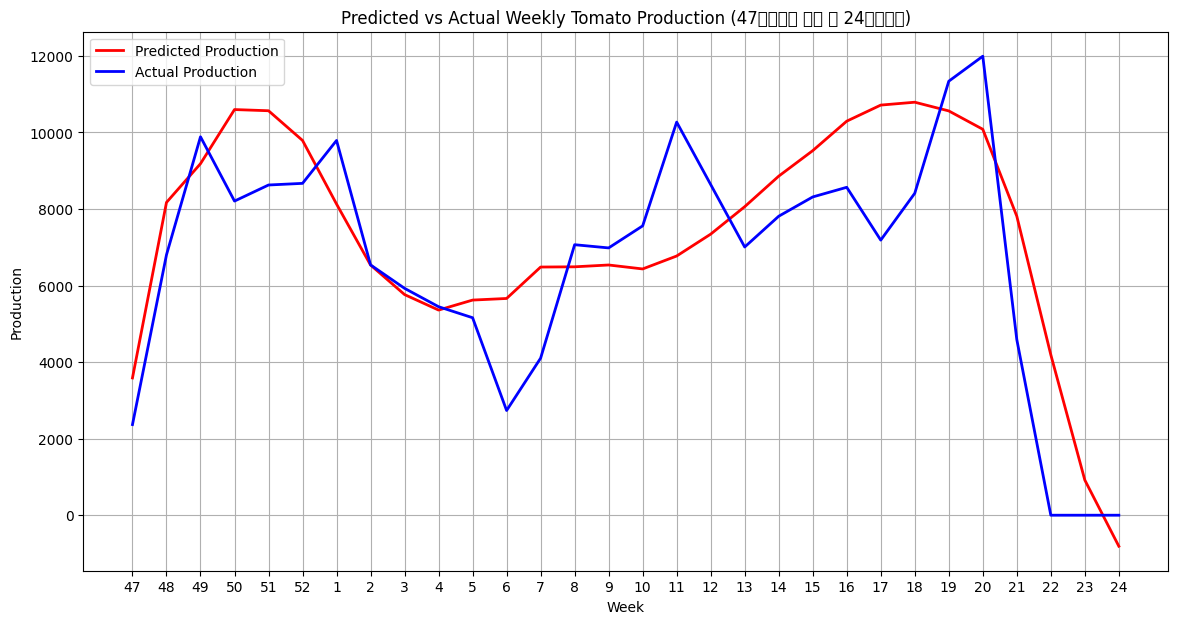

In [17]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 2. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 3. 적산 계산을 위한 데이터 그룹화 (주차별로 누적 합계 계산)
env_weekly_cumulative = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'sum',     # 온도 적산
    'inHd': 'sum',     # 습도 적산
    'inCo2': 'sum'     # CO2 적산
}).reset_index()

# 4. 생산량 데이터와 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_cumulative, 
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner').dropna(subset=['생산량'])

# 5. 특성과 타겟 데이터 분리
X = merged_data[['inTp', 'inHd', 'inCo2']].values  # 입력 변수 (온도, 습도, CO2 적산값)
y = merged_data['생산량'].values  # 타겟 변수 (생산량)

# 6. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 7. 시계열 데이터 준비
timesteps = 12  # 12주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 8. 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# 9. LSTM 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.GRU(50, activation='relu'),  # GRU 층 추가
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.Dense(forecast_weeks)  # 예측할 주차 수 만큼의 출력 뉴런
])

# RMSprop 최적화 알고리즘으로 모델 컴파일
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=64, callbacks=[early_stopping])

# 전체 데이터로 시퀀스 생성
X_full_sequences = []
for i in range(len(X_scaled) - timesteps + 1):
    X_full_sequences.append(X_scaled[i:i+timesteps])
X_full_sequences = np.array(X_full_sequences)

# 전체 데이터로 예측 수행
full_predictions = model.predict(X_full_sequences)
full_predictions_inverse = scaler_y.inverse_transform(full_predictions)

# 주차별 예측된 생산량 출력 (47주차부터 다음 해 24주차까지)
weeks_extended_full = np.concatenate([np.arange(47, 53), np.arange(1, 25)])  # 47주차부터 다음 해 24주차까지
filtered_predictions = full_predictions_inverse[:len(weeks_extended_full)]  # 주차 범위에 맞춰 예측값 슬라이싱

# 1. 데이터 로드
yield_data = pd.read_csv('전북군산생산량_변환.csv')

# 2. 47주차부터 다음 해 24주차까지 필터링
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])

# 4. 각 주차에 대응하는 생산량 데이터 가져오기
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended_full)]  # 주차에 맞춰 데이터 슬라이싱

# 그래프 시각화 (필요시)
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended_full)), filtered_predictions.flatten(), label='Predicted Production', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_extended_full)), actual_production, label='Actual Production', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_extended_full)), labels=weeks_extended_full)
plt.title('Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 24주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


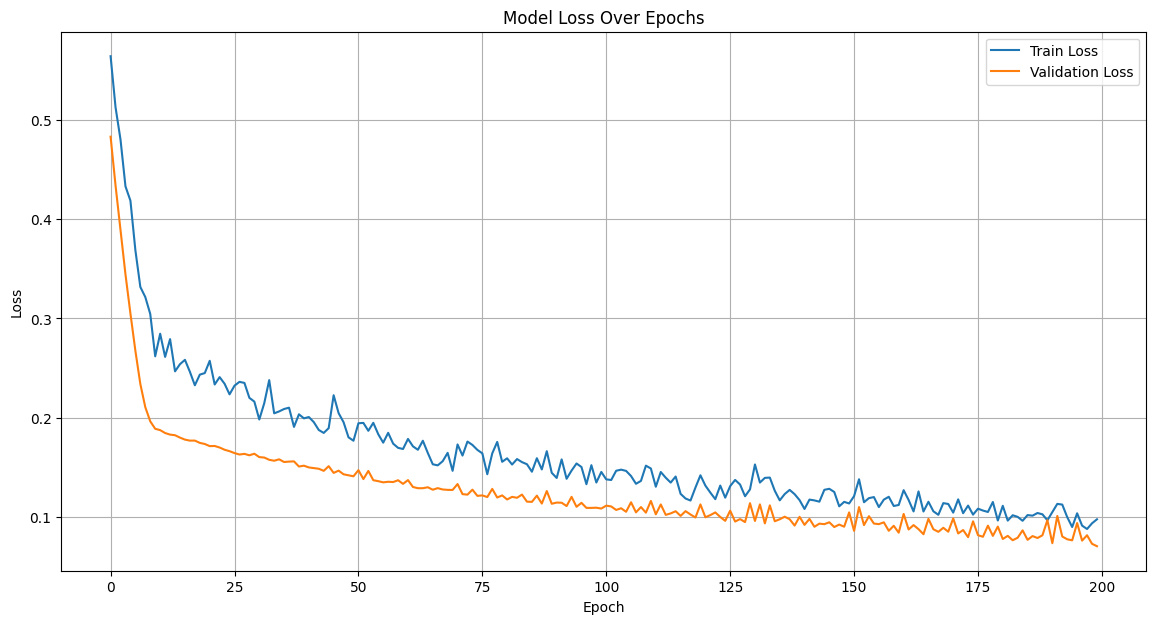

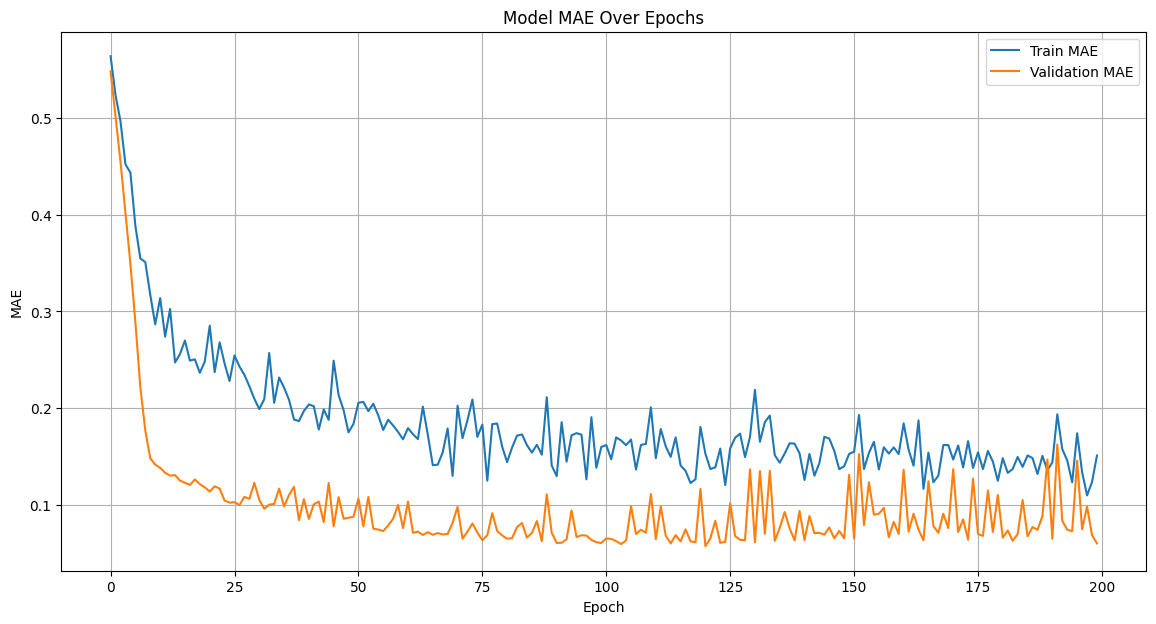

In [18]:
# 손실 함수의 변화를 그리기
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Mean Absolute Error (MAE)의 변화를 그리기
plt.figure(figsize=(14, 7))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 5. 실제 생산량 및 예측된 생산량을 모두 출력
print("주차별 실제 생산량 및 예측된 생산량:")
for i in range(len(weeks_extended_full)):
    print(f"{weeks_extended_full[i]}주차 실제 생산량 : {actual_production[i]}, 예측 생산량 : {filtered_predictions.flatten()[i]}")

주차별 실제 생산량 및 예측된 생산량:
47주차 실제 생산량 : 2368, 예측 생산량 : 4477.83203125
48주차 실제 생산량 : 6804, 예측 생산량 : 8185.689453125
49주차 실제 생산량 : 9888, 예측 생산량 : 9290.708984375
50주차 실제 생산량 : 8208, 예측 생산량 : 10736.16015625
51주차 실제 생산량 : 8628, 예측 생산량 : 10593.525390625
52주차 실제 생산량 : 8671, 예측 생산량 : 9705.6240234375
1주차 실제 생산량 : 9792, 예측 생산량 : 8057.9326171875
2주차 실제 생산량 : 6540, 예측 생산량 : 6633.09228515625
3주차 실제 생산량 : 5928, 예측 생산량 : 5927.54248046875
4주차 실제 생산량 : 5448, 예측 생산량 : 5441.3369140625
5주차 실제 생산량 : 5160, 예측 생산량 : 5630.0458984375
6주차 실제 생산량 : 2736, 예측 생산량 : 5650.82470703125
7주차 실제 생산량 : 4104, 예측 생산량 : 6455.39697265625
8주차 실제 생산량 : 7068, 예측 생산량 : 6481.38916015625
9주차 실제 생산량 : 6984, 예측 생산량 : 6548.46630859375
10주차 실제 생산량 : 7560, 예측 생산량 : 6421.068359375
11주차 실제 생산량 : 10272, 예측 생산량 : 6728.63623046875
12주차 실제 생산량 : 8640, 예측 생산량 : 7270.13623046875
13주차 실제 생산량 : 7008, 예측 생산량 : 7946.91259765625
14주차 실제 생산량 : 7812, 예측 생산량 : 8729.3984375
15주차 실제 생산량 : 8316, 예측 생산량 : 9415.142578125
16주차 실제 생산량 : 8568, 예측 생산량 : 10226.5791015

In [19]:
# 1. 22주차 이후의 데이터를 삭제
# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 22주차 이후의 데이터 삭제
yield_data = yield_data[yield_data['주차'] <= 21]

# 2. 날짜 데이터를 변환하고 주차 계산 (환경 데이터)
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 3. 적산 계산을 위한 데이터 그룹화 (주차별로 누적 합계 계산)
env_weekly_cumulative = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'sum',     # 내부 온도 적산
    'inHd': 'sum',     # 내부 습도 적산
    'inCo2': 'sum',    # CO2 적산
    'outTp': 'sum'     # 외부 온도 적산 (추가됨)
}).reset_index()

# 4. 생산량 데이터와 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_cumulative, 
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner').dropna(subset=['생산량'])

# 5. 특성과 타겟 데이터 분리
X = merged_data[['inTp', 'inHd', 'inCo2', 'outTp']].values  # 입력 변수 (온도, 습도, CO2, 외부 온도 적산값)
y = merged_data['생산량'].values  # 타겟 변수 (생산량)

# 6. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 7. 시계열 데이터 준비
timesteps = 12  # 12주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 8. 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# 9. LSTM 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.GRU(50, activation='relu'),  # GRU 층 추가
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.Dense(forecast_weeks)  # 예측할 주차 수 만큼의 출력 뉴런
])

# RMSprop 최적화 알고리즘으로 모델 컴파일
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=64, callbacks=[early_stopping])

# 전체 데이터로 시퀀스 생성
X_full_sequences = []
for i in range(len(X_scaled) - timesteps + 1):
    X_full_sequences.append(X_scaled[i:i+timesteps])
X_full_sequences = np.array(X_full_sequences)

# 전체 데이터로 예측 수행
full_predictions = model.predict(X_full_sequences)
full_predictions_inverse = scaler_y.inverse_transform(full_predictions)

# 주차별 예측된 생산량 출력 (47주차부터 다음 해 22주차까지)
weeks_extended_full = np.concatenate([np.arange(47, 53), np.arange(1, 23)])  # 47주차부터 다음 해 22주차까지

# 주차 범위에 맞춰 예측값 슬라이싱, 예측값과 주차 길이 맞추기
filtered_predictions = full_predictions_inverse[:len(weeks_extended_full)]  # 예측값을 주차 범위에 맞춤
filtered_predictions = filtered_predictions[:len(weeks_extended_full)]  # 길이를 맞춤

# 1. 데이터 로드
yield_data = pd.read_csv('전북군산생산량_변환.csv')

# 2. 47주차부터 다음 해 22주차까지 필터링
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 22)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])

# 4. 각 주차에 대응하는 생산량 데이터 가져오기
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended_full)]  # 주차에 맞춰 데이터 슬라이싱

# 예측값과 실제 생산량의 길이가 맞는지 확인
filtered_predictions = filtered_predictions.flatten()
assert len(filtered_predictions) == len(actual_production), "예측값과 실제 값의 길이가 일치하지 않습니다."

# 그래프 시각화 (필요시)
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended_full)), filtered_predictions, label='Predicted Production', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_extended_full)), actual_production, label='Actual Production', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_extended_full)), labels=weeks_extended_full)
plt.title('Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 22주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()



Epoch 1/200


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4266 - mae: 0.4878 - val_loss: 0.7628 - val_mae: 0.7573
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3946 - mae: 0.4536 - val_loss: 0.7254 - val_mae: 0.7330
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3730 - mae: 0.4255 - val_loss: 0.6860 - val_mae: 0.7063
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3404 - mae: 0.3900 - val_loss: 0.6432 - val_mae: 0.6757
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3147 - mae: 0.3534 - val_loss: 0.6023 - val_mae: 0.6449
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2898 - mae: 0.3247 - val_loss: 0.5572 - val_mae: 0.6091
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2769 - mae: 0.3005 - val_loss: 0.5119 - val_mae: 0.5703
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2548 - mae: 0.2619 - val_loss: 0.4684 - val_mae: 0.5301
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2301 - mae: 0.2384 - val_l

AssertionError: 예측값과 실제 값의 길이가 일치하지 않습니다.